# Deep fake detection challenge

#### Setup tensorflow to use GPU if available

In [19]:
import tensorflow as tf
import os

gpu = True
# Use gpu if available
if gpu:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    physical_devices = tf.config.list_physical_devices('GPU')
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    print(os.environ['CUDA_VISIBLE_DEVICES'])  # Check the value

Num GPUs Available:  1
0


#### Setup the seed for random number generators to ensure reproducibility

In [20]:
import random
import numpy as np
# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Pre-Procesing

### Step 1

- Load the data from the directory
- Extract 20 random frames from each video
- Use MTcnn to detect faces in the frames. If no face is detected, discard the frame. If more than one face is detected, take the first face since both faces have been faked similarly.
- Resize the frames to 224x224
- Save the frames in a new directory and create a new image_label.json file

This step takes a long time (174 min running on a Tesla V100-PCIE-32GB GPU).
Therefore we do this only once and save the processed images to a new directory.

In [21]:
import cv2
import imageio
import os
import random
import json
from mtcnn import MTCNN

# Paths
data_folder = "data"
output_folder = "data_images"

# If the output folder is not empty, skip processing
if os.path.exists(output_folder) and len(os.listdir(output_folder)) > 0:
    print("Skipping processing: 'data_images' folder is already populated.")
else:
    os.makedirs(output_folder, exist_ok=True)


    # Initialize MTCNN
    detector = MTCNN()

    # Parameters
    num_frames = 20
    frame_size = (224, 224)

    # Load labels from the existing metadata
    with open("data/metadata.json", "r") as f:
        video_labels = json.load(f)

    # Dictionary to store image-label mappings
    image_labels = {}

    # Process videos
    for video_name in os.listdir(data_folder):
        video_path = os.path.join(data_folder, video_name)

        if video_name.endswith(".mp4"):
            reader = imageio.get_reader(video_path, "ffmpeg")
            total_frames = reader.count_frames()

            # Select frame indices
            selected_frame_indices = sorted(random.sample(range(total_frames), num_frames))

            # Extract frames and process
            for i, frame in enumerate(reader):
                if i in selected_frame_indices:
                    frame_rgb = frame
                    if frame.ndim == 2:  # if grayscale
                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
                    elif frame.shape[2] == 4:  # if RGBA
                        frame_rgb = frame[:, :, :3]
                    # Detect faces in the frame and choose the first face
                    faces = detector.detect_faces(frame)
                    
                    # If no faces are found, skip this frame
                    if len(faces) == 0:
                        continue

                    # Get the bounding box of the first face
                    face = faces[0]
                    x, y, w, h = face['box']

                    # Crop the face region
                    face_crop = frame[y:y+h, x:x+w]
                    
                    if face_crop.size == 0:  # Ensure the cropped face is valid
                        continue
                    
                    # Resize the cropped face to 224x224
                    face_resized = cv2.resize(face_crop, frame_size)

                    # Generate a unique image name for the face
                    image_name = f"{video_name.split('.')[0]}_{i}.jpg"
                    image_path = os.path.join(output_folder, image_name)

                    # Save the resized face image
                    cv2.imwrite(image_path, face_resized)

                    # Store the label mapping
                    video_metadata = video_labels.get(video_name)
                    if video_metadata:
                        image_labels[image_name] = video_metadata["label"]

            reader.close()

    # Save the label mappings to a JSON file
    with open("image_labels.json", "w") as f:
        json.dump(image_labels, f, indent=4)

    print("Processing complete. Images saved in 'data_images', labels in 'image_labels.json'.")



Skipping processing: 'data_images' folder is already populated.


### Image Label Counts Plot
- The plot above visualizes the count of `REAL` and `FAKE` videos that have been processed in the pre-processing step. Keep in mind that the number of images is 20 times the number of videos.


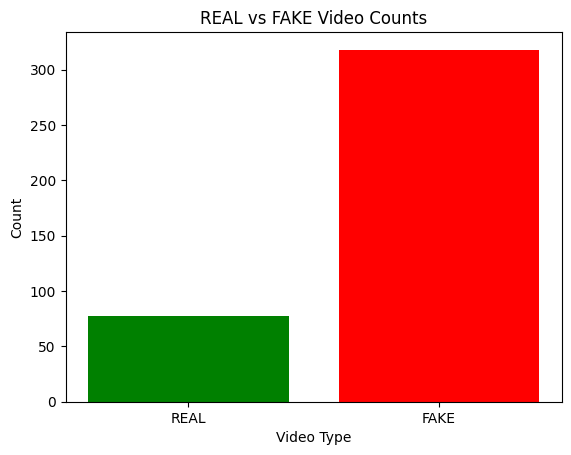

In [22]:
import matplotlib.pyplot as plt

image_labels = json.load(open("image_labels.json", "r"))

movie_labels = {}

for filename, label in image_labels.items():
    movie_name = filename.split("_")[0]  # Extract movie name
    movie_labels[movie_name] = label  # Store only one label per movie
    
# Count the number of unique REAL and FAKE videos
real_movies_count = sum(1 for label in movie_labels.values() if label == "REAL")
fake_movies_count = sum(1 for label in movie_labels.values() if label == "FAKE")

# Plotting the results
labels = ['REAL', 'FAKE']
counts = [real_movies_count, fake_movies_count]

plt.bar(labels, counts, color=['green', 'red'])
plt.xlabel('Video Type')
plt.ylabel('Count')
plt.title('REAL vs FAKE Video Counts')
plt.show()

### Step 2

- Assign the videos to fakes and reals classes

In [28]:
# load the images and labels and set it to a tf.data.Dataset

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

fakes = np.empty((0, 2), dtype=object)
reals = np.empty((0, 2), dtype=object)

for image, label in movie_labels.items():
    if label == "FAKE":
        
        fakes = np.append(fakes, np.array([[image, label]]), axis=0)
    else:
        reals = np.append(reals, np.array([[image, label]]), axis=0)
        
data = np.vstack((fakes, reals))

#### Perorm train-test split on the movies while stratifying on the labels. This is very important to spit by the videos and not by the frames to avoid data leakage between the train and test sets.


In [29]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=SEED, stratify=data[:, 1])

train, val = train_test_split(train, test_size=0.2, random_state=SEED, stratify=train[:, 1])


### Since we split by the videos we need to assign the corresponding images to the train and test sets

In [30]:
# Convert to sets for quick lookup
train_movies = set(train[:, 0])
val_movies = set(val[:, 0])
test_movies = set(test[:, 0])

# Function to filter images based on movie set
def get_images_from_movies(movie_set, image_labels):
    return np.array([[img, label] for img, label in image_labels.items() if img.split("_")[0] in movie_set], dtype=object)

# Filter images for each dataset
train_images = get_images_from_movies(train_movies, image_labels)
val_images = get_images_from_movies(val_movies, image_labels)
test_images = get_images_from_movies(test_movies, image_labels)

#### Plot the total number of images in each class


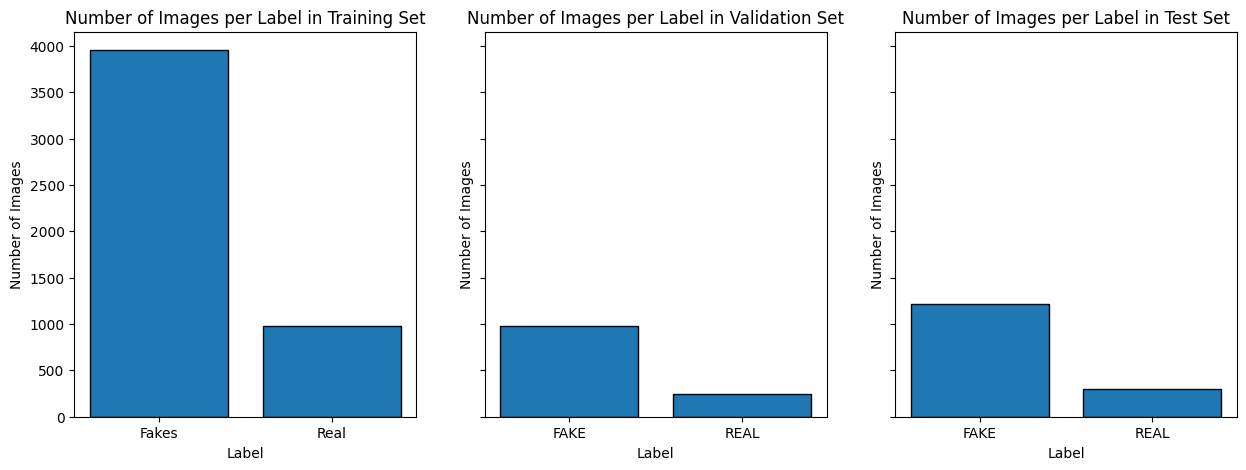

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

unique_labels, label_counts = np.unique(train_images[:, 1], return_counts=True)
axes[0].bar(unique_labels, label_counts, edgecolor='black')
axes[0].set_xticks(unique_labels)
axes[0].set_xticklabels(['Fakes', 'Real'])
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Number of Images per Label in Training Set')

unique_labels, label_counts = np.unique(val_images[:, 1], return_counts=True)
axes[1].bar(unique_labels, label_counts, edgecolor='black')
axes[1].set_xticks(unique_labels)
axes[0].set_xticklabels(['Fakes', 'Real'])
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Number of Images')
axes[1].set_title('Number of Images per Label in Validation Set')

unique_labels, label_counts = np.unique(test_images[:, 1], return_counts=True)
axes[2].bar(unique_labels, label_counts, edgecolor='black')
axes[2].set_xticks(unique_labels)
axes[0].set_xticklabels(['Fakes', 'Real'])
axes[2].set_xlabel('Label')
axes[2].set_ylabel('Number of Images')
axes[2].set_title('Number of Images per Label in Test Set')

# Display the plot
plt.show()

#### Save the images under train, test and val folders with the respective labels in the folder name

Mapping the labels to integers:

REAL → 0

FAKE → 1

In [33]:
from PIL import Image

# Mapping labels
label_mapping = {"REAL": 0, "FAKE": 1}


def save_images(data, base_folder):
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)
    for img_path, label in data:
        # Convert label to 0 or 1
        numeric_label = label_mapping[label]
        
        label_folder = os.path.join(base_folder, str(numeric_label))
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)
        img = Image.open("data_images/" + img_path)
        img.save(os.path.join(label_folder, os.path.basename(img_path)))

if os.path.exists('train') and os.path.exists('val') and os.path.exists('test') and len(os.listdir(output_folder)) > 0:
    print("Skipping processing: 'train, val, test' folder is already full.")
else:
    # Save the images for each dataset
    save_images(train_images, 'train')
    save_images(val_images, 'val')
    save_images(test_images, 'test')

## SSIM Masks

### Take the mean of all the real images from the train dataset 

In [43]:
# --- Calculate average real image for SSIM ---
real_train_dir = os.path.join('train', '0')  # Assuming '0' is REAL class
real_image_files = [os.path.join(real_train_dir, f) for f in os.listdir(real_train_dir)]

# Compute average of all real training images
avg_real_image = np.zeros((224, 224), dtype=np.float32)
for img_file in real_image_files:
    img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (224, 224))
        avg_real_image += img.astype(np.float32)
avg_real_image /= len(real_image_files)
avg_real_image = avg_real_image.astype(np.uint8)

### Use this average image and calculate the SSIM between this and all the images in the dataset and save the SSIM values in a dictionary

In [49]:
from skimage.metrics import structural_similarity as ssim

def precompute_ssim_masks(dataset_dir, save_dir, avg_real_image):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for label in os.listdir(dataset_dir):
        label_dir = os.path.join(dataset_dir, label)
        label_save_dir = os.path.join(save_dir, label)
        os.makedirs(label_save_dir, exist_ok=True)  # Create label directory

        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                img = cv2.resize(img, (224, 224))

                # Compute SSIM map
                _, ssim_map = ssim(img, avg_real_image, full=True)

               # Normalize to [0,1] and save as float32 numpy array
                ssim_map = (ssim_map - ssim_map.min()) / (ssim_map.max() - ssim_map.min())
                mask_path = os.path.join(label_save_dir, f"{os.path.splitext(img_file)[0]}.npy")
                np.save(mask_path, ssim_map.astype(np.float32))
                
# Precompute SSIM masks for each dataset
if os.path.exists('train_ssim') and os.path.exists('val_ssim') and os.path.exists('test_ssim'):
    print("Skipping processing: 'train_ssim, val_ssim, test_ssim' folder is already full.")
else:
    # Save the images for each dataset
    precompute_ssim_masks("train", 'train_ssim', avg_real_image)
    precompute_ssim_masks("val", 'val_ssim', avg_real_image)
    precompute_ssim_masks("test", 'test_ssim', avg_real_image)


#### Load the images from the folders and perform data augmentation


In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
# Create ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0, 1]
    rotation_range=10,           # Randomly rotate images by up to 10 degrees
    width_shift_range=0.1,       # Randomly shift images horizontally by 10% of the width
    height_shift_range=0.1,      # Randomly shift images vertically by 10% of the height
    shear_range=0.2,             # Apply shearing transformations
    zoom_range=0.1,              # Randomly zoom in or out by 20%
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Fill missing pixels after transformations,

)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# Create generators
train_generator = train_datagen.flow_from_directory(
    'train',                   
    target_size=(224, 224),     
    batch_size=batch_size,              
    class_mode='binary'    
)

val_generator = val_datagen.flow_from_directory(
    'val', 
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    'test', 
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

Found 4936 images belonging to 2 classes.
Found 1220 images belonging to 2 classes.
Found 1516 images belonging to 2 classes.


### Make a dual data generator to include the SSIM Masks as an additional input to the model

In [74]:
def dual_input_generator(base_gen, ssim_dir):
    while True:
        batch_x, batch_y = next(base_gen)

        batch_ssim = []
        for img_path in base_gen.filepaths:  # Use full filepaths
            # Get corresponding SSIM mask path
            rel_path = os.path.relpath(img_path, base_gen.directory)
            mask_path = os.path.join(ssim_dir, os.path.splitext(rel_path)[0] + '.npy')
            
            # Load SSIM mask
            ssim_map = np.load(mask_path)
            ssim_map = cv2.resize(ssim_map, (224, 224))  # Ensure correct size
            ssim_map = np.expand_dims(ssim_map, axis=-1)  # Add channel dimension
            batch_ssim.append(ssim_map)
        
        yield [batch_x, np.array(batch_ssim)], batch_y

# Create final generators
train_generator_dual = dual_input_generator(train_generator, 'train_ssim')
val_generator_dual = dual_input_generator(val_generator, 'val_ssim')
test_generator_dual = dual_input_generator(test_generator, 'test_ssim')

# Model

In [75]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight("balanced", classes=np.array([0, 1]), y=train_generator.classes)

# Convert to dictionary format for Keras
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Computed class weights:", class_weight_dict)

Computed class weights: {0: 2.5183673469387755, 1: 0.6238624873609707}


## Lightweight Model

In [76]:
from tensorflow.keras.applications import MobileNetV2  # Smaller than EfficientNet
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Model

# 1. MobileNet branch (RGB images) - Much smaller than EfficientNet
rgb_input = Input(shape=(192, 192, 3))  # Reduced resolution
model = MobileNetV2(include_top=False, 
                       weights='imagenet', 
                       input_tensor=rgb_input,
                       alpha=0.5)  # Width multiplier (0.5 makes it smaller)

for layer in model.layers:
    layer.trainable = False  # Freeze for transfer learning

rgb_features = GlobalAveragePooling2D()(model.output)  # (1280,)

# 2. Simplified SSIM branch
ssim_input = Input(shape=(192, 192, 1))  # Match reduced resolution

x = Conv2D(16, (3,3), activation='relu')(ssim_input)
x = MaxPooling2D(2)(x)  # 96x96

x = Conv2D(32, (3,3), activation='relu')(x)
x = MaxPooling2D(2)(x)  # 48x48

x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2)(x)  # 24x24

x = Flatten()(x)

# 3. Combine features
combined = Concatenate()([rgb_features, x])

# 4. Classification head
output = Dense(1, activation='sigmoid')(combined)

model = Model(inputs=[rgb_input, ssim_input], outputs=output)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 96, 96, 16)   432         ['input_9[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 96, 96, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 96, 96, 16)   0           ['bn_Conv1[0][0]']         

In [77]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint_cb = ModelCheckpoint("best_model.h5", 
                                monitor="val_loss", 
                                save_best_only=True, 
                                mode="min", 
                                verbose=1)

early_stopping_cb = EarlyStopping(monitor="val_loss", 
                                  patience=5,  # Stop if val_loss doesn't improve for 5 epochs
                                  restore_best_weights=True, 
                                  verbose=1)


In [78]:
history = model.fit(
    train_generator_dual,
    steps_per_epoch=len(train_generator),  # Use original generator's length
    validation_data=val_generator_dual,
    validation_steps=len(val_generator),   # Use original generator's length
    epochs=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
    class_weight=class_weight_dict,
    verbose=1
)

MemoryError: Unable to allocate 945. MiB for an array with shape (4936, 224, 224, 1) and data type float32

In [53]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# 1. EfficientNet branch (RGB images)
rgb_input = Input(shape=(224, 224, 3))
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=rgb_input)

for layer in base_model.layers:
    layer.trainable = False  # Freeze EfficientNet layers for transfer learning

rgb_features = base_model.output  # Shape: (7, 7, 1280)

# 2. SSIM branch (Grayscale input)
ssim_input = Input(shape=(224, 224, 1))

x_ssim = Conv2D(32, (3,3), activation='relu', padding='same')(ssim_input)
x_ssim = MaxPooling2D((2,2))(x_ssim)  # (112, 112, 32)

x_ssim = Conv2D(64, (3,3), activation='relu', padding='same')(x_ssim)
x_ssim = MaxPooling2D((2,2))(x_ssim)  # (56, 56, 64)

x_ssim = Conv2D(128, (3,3), activation='relu', padding='same')(x_ssim)
x_ssim = MaxPooling2D((2,2))(x_ssim)  # (28, 28, 128)

x_ssim = Conv2D(256, (3,3), activation='relu', padding='same')(x_ssim)
x_ssim = MaxPooling2D((2,2))(x_ssim)  # (14, 14, 256)

x_ssim = Conv2D(512, (3,3), activation='relu', padding='same')(x_ssim)
x_ssim = MaxPooling2D((2,2))(x_ssim)  # (7, 7, 512)

# Match EfficientNet's output channels
x_ssim = Conv2D(1280, (1,1), activation='relu')(x_ssim)  # (7, 7, 1280)

# 3. Combine EfficientNet and SSIM features
combined = Concatenate()([rgb_features, x_ssim])  # (7, 7, 2560)

# 4. Classification head
x = GlobalAveragePooling2D()(combined)  # (2560,)
output = Dense(1, activation='sigmoid')(x)

# 5. Model definition
model = Model(inputs=[rgb_input, ssim_input], outputs=output)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                              

In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint_cb = ModelCheckpoint("best_model.h5", 
                                monitor="val_loss", 
                                save_best_only=True, 
                                mode="min", 
                                verbose=1)

early_stopping_cb = EarlyStopping(monitor="val_loss", 
                                  patience=5,  # Stop if val_loss doesn't improve for 5 epochs
                                  restore_best_weights=True, 
                                  verbose=1)


In [65]:
history = model.fit(
    train_generator_dual,
    steps_per_epoch=len(train_generator),  # Use original generator's length
    validation_data=val_generator_dual,
    validation_steps=len(val_generator),   # Use original generator's length
    epochs=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/2


ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2d_2/Relu' defined at (most recent call last):
    File "c:\Users\shegg\.conda\envs\py310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\shegg\.conda\envs\py310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\shegg\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\shegg\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\shegg\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\shegg\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\shegg\.conda\envs\py310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\shegg\.conda\envs\py310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\shegg\.conda\envs\py310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\shegg\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue
      await self.process_one()
    File "C:\Users\shegg\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 531, in process_one
      await dispatch(*args)
    File "C:\Users\shegg\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\shegg\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\shegg\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 775, in execute_request
      reply_content = await reply_content
    File "C:\Users\shegg\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "C:\Users\shegg\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\shegg\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "C:\Users\shegg\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "C:\Users\shegg\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\shegg\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\shegg\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\shegg\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\shegg\AppData\Local\Temp\ipykernel_16732\4011942989.py", line 1, in <module>
      history = model.fit(
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\shegg\.conda\envs\py310\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model/conv2d_2/Relu'
OOM when allocating tensor with shape[4936,224,224,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_2/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_18956]